In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import json
import time

In [ ]:

# GPU varsa kullan, yoksa CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

Tokenizer

In [3]:
def load_vocab_from_json(json_file_path):
    with open(json_file_path, 'r', encoding='utf-8') as f:
        tokenizer_data = json.load(f)

    vocab = tokenizer_data['model']['vocab']
    return vocab

In [5]:
vocab = load_vocab_from_json("/content/my_bpe_tokenizer_dia.json")

In [6]:
vocab

{'<unk>': 0,
 '!': 1,
 '"': 2,
 '$': 3,
 '%': 4,
 '&': 5,
 "'": 6,
 '(': 7,
 ')': 8,
 ',': 9,
 '-': 10,
 '.': 11,
 '/': 12,
 '0': 13,
 '1': 14,
 '2': 15,
 '3': 16,
 '4': 17,
 '5': 18,
 '6': 19,
 '7': 20,
 '8': 21,
 '9': 22,
 ':': 23,
 ';': 24,
 '=': 25,
 '?': 26,
 'A': 27,
 'B': 28,
 'C': 29,
 'D': 30,
 'E': 31,
 'F': 32,
 'G': 33,
 'H': 34,
 'I': 35,
 'J': 36,
 'K': 37,
 'L': 38,
 'M': 39,
 'N': 40,
 'O': 41,
 'P': 42,
 'Q': 43,
 'R': 44,
 'S': 45,
 'T': 46,
 'U': 47,
 'V': 48,
 'W': 49,
 'X': 50,
 'Y': 51,
 'Z': 52,
 'a': 53,
 'b': 54,
 'c': 55,
 'd': 56,
 'e': 57,
 'f': 58,
 'g': 59,
 'h': 60,
 'i': 61,
 'j': 62,
 'k': 63,
 'l': 64,
 'm': 65,
 'n': 66,
 'o': 67,
 'p': 68,
 'q': 69,
 'r': 70,
 's': 71,
 't': 72,
 'u': 73,
 'v': 74,
 'w': 75,
 'x': 76,
 'y': 77,
 'z': 78,
 '~': 79,
 '£': 80,
 '¥': 81,
 '—': 82,
 '‘': 83,
 '′': 84,
 '。': 85,
 'er': 86,
 'on': 87,
 'ers': 88,
 'erson': 89,
 'Person': 90,
 'th': 91,
 'ou': 92,
 'in': 93,
 'an': 94,
 'you': 95,
 're': 96,
 'at': 97,
 'the

In [7]:
class UstaTokenizer:
    def __init__(self, vocab):
        self.vocab = vocab
        self.reverse_vocab = {v: k for k, v in self.vocab.items()}

        # Özel token'ları kontrol et
        self.unk_token = "<unk>" if "<unk>" in vocab else None
        self.pad_token = "<pad>" if "<pad>" in vocab else None

        # Boşluk token'ını bul
        self.space_token = None
        if " " in vocab:
            self.space_token = " "
        elif "Ġ" in vocab:  # GPT-2 style
            self.space_token = "Ġ"
        elif "▁" in vocab:  # SentencePiece style
            self.space_token = "▁"
        else:
            print("⚠️ Boşluk token'ı bulunamadı! Boşluklar atlanacak.")

        # Vocab boyutunu kontrol et
        print(f"📊 Vocab boyutu: {len(self.vocab)}")
        print(f"🔑 Max token ID: {max(self.vocab.values()) if self.vocab else 0}")

        # Özel token'ları yazdır
        special_tokens = [k for k in vocab.keys() if k.startswith('<') and k.endswith('>')]
        print(f"🏷️ Özel token'lar: {special_tokens}")

    def encode(self, text):
        tokens = []

        for word in text.split():
            i = 0
            while i < len(word):
                found_match = False
                # En uzun eşleşmeyi bul (greedy matching)
                for j in range(len(word), i, -1):
                    sub_word = word[i:j]
                    if sub_word in self.vocab:
                        tokens.append(self.vocab[sub_word])
                        i = j
                        found_match = True
                        break

                if not found_match:
                    # Bilinmeyen token için kontrol
                    if self.unk_token:
                        tokens.append(self.vocab[self.unk_token])
                    else:
                        # Eğer <unk> yoksa, karakteri atla veya hata ver
                        print(f"⚠️ Bilinmeyen karakter: '{word[i]}' - atlanıyor")
                    i += 1

            # Boşluk token'ı varsa ekle (kelimeler arası)
            if self.space_token:
                tokens.append(self.vocab[self.space_token])

        # Eğer text boşlukla bitmiyorsa, son boşluk token'ını kaldır
        if not text.endswith(" ") and tokens and self.space_token:
            if tokens[-1] == self.vocab[self.space_token]:
                tokens.pop()

        return torch.tensor(tokens, dtype=torch.long)

    def tokenize(self, text):
        token_ids = self.encode(text)
        # Tensor'u listeye çevir
        if hasattr(token_ids, 'detach'):
            token_ids = token_ids.detach().cpu().numpy().tolist()
        else:
            token_ids = token_ids.tolist()

        # ID'leri token'lara çevir
        tokens = []
        for id in token_ids:
            if id in self.reverse_vocab:
                tokens.append(self.reverse_vocab[id])
            else:
                print(f"⚠️ Hata: ID {id} vocab'da bulunamadı!")
                tokens.append("<unk>")

        return tokens

    def decode(self, ids):
        text = ""
        for id in ids:
            if isinstance(id, torch.Tensor):
                id = id.item()

            if id in self.reverse_vocab:
                token = self.reverse_vocab[id]
                # Boşluk token'larını işle
                if token == self.space_token:
                    text += " "
                elif token.startswith("Ġ"):  # GPT-2 style
                    text += " " + token[1:]
                elif token.startswith("▁"):  # SentencePiece style
                    text += " " + token[1:]
                else:
                    text += token
            else:
                print(f"⚠️ Decode hatası: ID {id} bulunamadı!")
                text += "<unk>"

        return text.strip()

    def get_vocab_info(self):
        """Vocab hakkında detaylı bilgi"""
        print(f"📊 Toplam vocab boyutu: {len(self.vocab)}")
        print(f"🔢 Token ID aralığı: 0 - {max(self.vocab.values())}")
        print(f"🏷️ Özel token sayısı: {len([k for k in self.vocab if k.startswith('<')])}")

        # En sık kullanılan 10 token
        sorted_vocab = sorted(self.vocab.items(), key=lambda x: x[1])[:10]
        print("🔝 İlk 10 token:")
        for token, id in sorted_vocab:
            print(f"  {id}: '{token}'")

In [8]:
u_tokenizer = UstaTokenizer(vocab)

⚠️ Boşluk token'ı bulunamadı! Boşluklar atlanacak.
📊 Vocab boyutu: 10500
🔑 Max token ID: 10499
🏷️ Özel token'lar: ['<unk>']


In [9]:
def load_dataset_efficiently(dataset_path, max_chars=None):
    """Dataset'i memory efficient şekilde yükler"""
    print(f"Loading dataset from {dataset_path}...")

    try:
        with open(dataset_path, 'r', encoding='utf-8') as f:
            if max_chars:
                text = f.read(max_chars)  # Sadece belirli miktarda oku
                print(f"✓ Dataset loaded (first {max_chars} chars)")
            else:
                text = f.read()
                print(f"✓ Dataset loaded completely ({len(text)} chars)")

        return text

    except FileNotFoundError:
        print(f"❌ {dataset_path} not found!")
        return None
    except Exception as e:
        print(f"❌ Error loading dataset: {str(e)}")
        return None

In [10]:
text = load_dataset_efficiently("/content/dialogues.txt")

Loading dataset from /content/dialogues.txt...
✓ Dataset loaded completely (1257133 chars)


Model

# Embedding


In [11]:
def get_rotary_position_encoding(input, base=10000, device=None):
    # Eğer device verilmezse input'un device'ını kullan
    if device is None:
        device = input.device

    context_length, dimension = input.shape
    assert dimension % 2 == 0, "dimension must be even"

    half_dimension = dimension // 2
    freqs_indices = torch.arange(0, half_dimension, device=device, dtype=torch.float32)
    freqs = 1.0 / (base ** (freqs_indices / dimension))

    positions = torch.arange(0, context_length, device=device, dtype=torch.float32).unsqueeze(1)
    angles = positions * freqs

    sin_angles = torch.sin(angles)
    cos_angles = torch.cos(angles)

    input_even = input[:, :dimension // 2]  # [0, 2, 4, ..]
    input_odd = input[:, dimension // 2:]   # [1, 3, 5, ..]

    input_even_rotated = input_even * cos_angles - input_odd * sin_angles
    input_odd_rotated = input_even * sin_angles + input_odd * cos_angles

    input_rotated = torch.empty_like(input, device=device)
    input_rotated[:, :dimension // 2] = input_even_rotated
    input_rotated[:, dimension // 2:] = input_odd_rotated

    return input_rotated


# Alternatif olarak, model içinde çağırırken device'ı explicit ver:
# rotary_output = get_rotary_position_encoding(x, device=x.device)

In [12]:
class UstaEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_length):
        super().__init__()
        # position embedding but not being used in the forward pass
        # it is just for educational purposes
        # self.pos_embedding = nn.Embedding(context_length, embedding_dim)

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.get_pos = get_rotary_position_encoding

    def forward(self, x):
        x = self.embedding(x)
        x = self.get_pos(x)
        return x

# Multi Head Attention

In [13]:
class UstaMultiHeadAttention(nn.Module):
  def __init__(self, embedding_dim, output_dim, context_length, num_heads, dropout_rate = 0):
    super().__init__()

    self.context_length = context_length

    self.multi_head_attention = nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout_rate)
    self.projection = nn.Linear(embedding_dim, output_dim)

    self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

  def forward(self, x):
    number_of_tokens = x.shape[0]
    x = x[:self.context_length]
    attention_mask = self.mask[:number_of_tokens, :number_of_tokens]
    out, _ = self.multi_head_attention(x, x, x, attn_mask=attention_mask)
    out = self.projection(out)
    return out

# Layer Normalization


In [14]:
class UstaLayerNorm(nn.Module):
  def __init__(self, embedding_dim, eps=1e-5):
    super().__init__()
    self.eps = eps

    self.weight = nn.Parameter(torch.ones(embedding_dim))


  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    variance = x.var(dim=-1, keepdim=True, unbiased=False)
    normalized_x = (x - mean) / torch.sqrt(variance + self.eps)
    return self.weight * normalized_x

# MLP Block


In [15]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (
      1 + torch.tanh(
          torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
        )
    )

class UstaMLP(nn.Module):
  def __init__(self, embedding_dim, hidden_dim):
    super().__init__()

    self.gate_proj = nn.Linear(embedding_dim, hidden_dim)
    self.up_proj = nn.Linear(embedding_dim, hidden_dim)
    self.down_proj = nn.Linear(hidden_dim, embedding_dim)
    self.gelu = GELU()

  def forward(self, x):
    """ gate = self.gate_proj(x)
        gate = F.gelu(gate, approximate="tanh")
        up = self.up_proj(x)
        fuse = gate * up
        outputs = self.down_proj(fuse) """
    gate = self.gate_proj(x)
    gate = self.gelu(gate)
    up = self.up_proj(x)
    fuse = gate * up
    outputs = self.down_proj(fuse)
    return outputs

# Decoder Block

In [16]:
class UstaDecoderBlock(nn.Module):
  def __init__(self, embedding_dim, num_heads, context_length):
    super().__init__()

    self.self_attention = UstaMultiHeadAttention(embedding_dim, embedding_dim, context_length, num_heads, dropout_rate=0.5)
    self.norm1 = UstaLayerNorm(embedding_dim)
    self.mlp = UstaMLP(embedding_dim, embedding_dim)
    self.norm2 = UstaLayerNorm(embedding_dim)

  def forward(self, x):
    res = self.norm1(x)

    x = self.self_attention(x)
    x = self.norm1(x)

    x = x + res

    res = self.norm2(x)
    x = self.mlp(x)
    x = self.norm2(x)

    x = x + res

    return x

# Model Construction


In [17]:
class UstaModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, num_heads, context_length, num_layers):
    super().__init__()

    self.embedding = UstaEmbedding(vocab_size, embedding_dim, context_length)
    self.layers = nn.Sequential(
      *[UstaDecoderBlock(embedding_dim, num_heads, context_length) for _ in range(num_layers)]
    )

    self.lm_head = nn.Linear(embedding_dim, vocab_size)

  def forward(self, x: torch.Tensor):
    x = self.embedding(x) # dictionary meaning of the tokens (words)

    x = self.layers(x)
    x = self.lm_head(x)

    return x


  """ out = u_model(torch.tensor(new_tokens))

  probs = torch.softmax(out[-1], dim=-1)
  max_prob, max_index = torch.max(probs, dim=-1)
  max_prob, max_index, probs
  """

  def generate(self, x: torch.Tensor, max_new_tokens: int): # top_k, top_p, temperature
    tokens = x.detach().cpu().numpy().tolist()

    for _ in range(max_new_tokens):
      out = self.forward(x)
      probs = torch.softmax(out[-1], dim=-1)
      _, max_index = torch.max(probs, dim=-1)
      tokens.append(max_index.item())
      if max_index == 59 or len(tokens) > 32: # <eos> and max context length
        break

      x = torch.tensor(tokens)

    return tokens


# Training

In [18]:
context_length = 32

In [19]:
u_tokenizer = UstaTokenizer(vocab)

prompt = "the capital of the united"

tokens = u_tokenizer.encode(prompt)
tokens

⚠️ Boşluk token'ı bulunamadı! Boşluklar atlanacak.
📊 Vocab boyutu: 10500
🔑 Max token ID: 10499
🏷️ Özel token'lar: ['<unk>']


tensor([  98, 5516,  120,   98, 4547,  149])

In [20]:
torch.manual_seed(1)
u_model = UstaModel(vocab_size=len(u_tokenizer.vocab), embedding_dim=12, num_heads=4, context_length=context_length, num_layers=8)

# Use the first input from the dataset for the forward pass
# out = u_model(dataset.inputs[0])
# out.shape

In [21]:
token_ids = u_tokenizer.encode(text)
len(token_ids), type(token_ids)

(315507, torch.Tensor)

In [22]:
ids = token_ids.detach().cpu().numpy().tolist()
len(ids), type(ids)

(315507, list)

# Text Dataset

In [23]:
pad_id = 63

class TextDataset(Dataset):
  def __init__(self, token_ids: list, context_length: int, stride: int):
    super().__init__()

    self.inputs = []
    self.targets = []

    for i in range(0, len(token_ids) - context_length, stride):
      input_chunk = token_ids[i:i + context_length]
      target_chunk = token_ids[i + 1:i + context_length + 1]

      # truncate to context length
      input_chunk = input_chunk[:context_length]
      target_chunk = target_chunk[:context_length]

      # pad to context length
      input_chunk = input_chunk + [pad_id] * (context_length - len(input_chunk))
      target_chunk = target_chunk + [pad_id] * (context_length - len(target_chunk))

      # truncate to context length
      input_chunk = input_chunk[:context_length]
      target_chunk = target_chunk[:context_length]

      self.inputs.append(torch.tensor(input_chunk, dtype=torch.long))
      self.targets.append(torch.tensor(target_chunk, dtype=torch.long))

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]


def create_data_loader(token_ids: list, context_length: int, stride: int,
                       batch_size: int, shuffle: bool = True, device: str = "cpu"):
  dataset = TextDataset(token_ids, context_length, stride)
  dataloader = DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=shuffle,
      generator=torch.Generator(device=device)
    )

  return dataloader

In [24]:
stride = 12

dataset = TextDataset(ids, context_length, stride)

len(dataset.inputs), len(dataset.targets)

(26290, 26290)

In [25]:
# model parameters count
parameters_count = sum(p.numel() for p in u_model.parameters())
print(parameters_count)

# model architecture
print(u_model)

272676
UstaModel(
  (embedding): UstaEmbedding(
    (embedding): Embedding(10500, 12)
  )
  (layers): Sequential(
    (0): UstaDecoderBlock(
      (self_attention): UstaMultiHeadAttention(
        (multi_head_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
        )
        (projection): Linear(in_features=12, out_features=12, bias=True)
      )
      (norm1): UstaLayerNorm()
      (mlp): UstaMLP(
        (gate_proj): Linear(in_features=12, out_features=12, bias=True)
        (up_proj): Linear(in_features=12, out_features=12, bias=True)
        (down_proj): Linear(in_features=12, out_features=12, bias=True)
        (gelu): GELU()
      )
      (norm2): UstaLayerNorm()
    )
    (1): UstaDecoderBlock(
      (self_attention): UstaMultiHeadAttention(
        (multi_head_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
        )


In [26]:
out0 = u_model(dataset.inputs[0])
out0.shape

torch.Size([32, 10500])

# Loss Function

In [27]:
loss_fn = nn.CrossEntropyLoss()

In [28]:
loss = loss_fn(out0, dataset.targets[0])
loss

tensor(9.8345, grad_fn=<NllLossBackward0>)

# Optimizer

In [29]:
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.AdamW(u_model.parameters(), lr=1e-3)

In [30]:
for input, target in dataset:
  print(input.shape, target.shape)
  break

torch.Size([32]) torch.Size([32])


In [31]:
# ÖNEMLİ: Model GPU'ya taşı
u_model = u_model.to(device)
print(f"Model device: {next(u_model.parameters()).device}")

Model device: cuda:0


Dataset boyutu: 26290
Başlangıç epochs: 20
Early stopping: 10 epoch patience

🚀 EPOCH 1/20
  Batch 0, Loss: 9.7664
  Batch 2000, Loss: 6.6966
  Batch 4000, Loss: 5.1715
  Batch 6000, Loss: 4.4472
  Batch 8000, Loss: 4.7425
  Batch 10000, Loss: 6.2761
  Batch 12000, Loss: 3.8171
  Batch 14000, Loss: 4.3354
  Batch 16000, Loss: 3.7717
  Batch 18000, Loss: 3.9750
  Batch 20000, Loss: 3.8769
  Batch 22000, Loss: 5.7618
  Batch 24000, Loss: 3.1998
  Batch 26000, Loss: 3.8308
✅ Epoch 1 - Avg Loss: 4.9935 (1034.1s)
🎯 En iyi loss güncellendi: 4.9935

🚀 EPOCH 2/20
  Batch 0, Loss: 4.3394
  Batch 2000, Loss: 5.6512
  Batch 4000, Loss: 4.3718
  Batch 6000, Loss: 3.1673
  Batch 8000, Loss: 3.9403
  Batch 10000, Loss: 5.6180
  Batch 12000, Loss: 2.8368
  Batch 14000, Loss: 4.0642
  Batch 16000, Loss: 3.5127
  Batch 18000, Loss: 3.6819
  Batch 20000, Loss: 3.3463
  Batch 22000, Loss: 5.4762
  Batch 24000, Loss: 3.2213
  Batch 26000, Loss: 3.5731
✅ Epoch 2 - Avg Loss: 4.4370 (1032.7s)
🎯 En iyi loss g

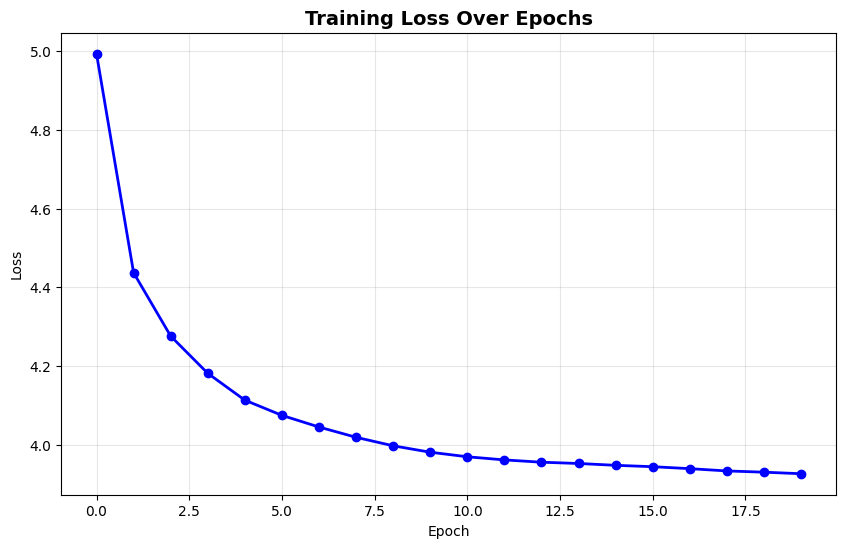


💡 Öneri: Loss hâlâ yüksek. epochs = 50-100 ile tekrar dene.


In [33]:
# 1. Loss takibi için liste
loss_history = []

# 2. Early stopping için değişkenler
best_loss = float('inf')
patience = 10  # 10 epoch loss düşmezse dur (artırıldı)
patience_counter = 0

# 3. Epochs - artırıldı
epochs = 20  # 20 epoch ile başla

# 4. Learning rate scheduler ekle
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print(f"Dataset boyutu: {len(dataset)}")
print(f"Başlangıç epochs: {epochs}")
print(f"Early stopping: {patience} epoch patience")

for epoch in range(epochs):
    print(f"\n🚀 EPOCH {epoch + 1}/{epochs}")

    start_time = time.time()
    total_loss = 0.

    # Eğitim döngüsü
    for batch_idx, (input, target) in enumerate(dataset):
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        pred = u_model(input)
        loss = loss_fn(pred, target)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        # Daha az frequent print (2000'de bir)
        if batch_idx % 2000 == 0:
            print(f"  Batch {batch_idx}, Loss: {loss.item():.4f}")

    epoch_time = time.time() - start_time
    average_loss = total_loss / len(dataset)
    loss_history.append(average_loss)

    print(f"✅ Epoch {epoch + 1} - Avg Loss: {average_loss:.4f} ({epoch_time:.1f}s)")

    # Learning rate scheduler step
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(average_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if old_lr != new_lr:
        print(f"🔽 Learning rate reduced: {old_lr:.6f} → {new_lr:.6f}")

    if average_loss < best_loss:
        best_loss = average_loss
        patience_counter = 0
        print(f"🎯 En iyi loss güncellendi: {best_loss:.4f}")

        # Model kaydet
        torch.save(u_model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        print(f"⚠️  Loss düşmedi, patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"🛑 Early stopping! {patience} epoch boyunca iyileşme yok.")
            break

    # Loss trend analizi
    if len(loss_history) >= 3:
        recent_trend = loss_history[-3:]
        if all(recent_trend[i] <= recent_trend[i-1] for i in range(1, len(recent_trend))):
            print("📈 Loss düzenli düşüyor, devam et!")
        else:
            print("📊 Loss dalgalı, learning rate scheduler devrede")

    # İlerleme durumu
    if average_loss < 2.0:
        print("🌟 Loss 2.0'ın altında! İyi gidiyor.")
    elif average_loss < 1.0:
        print("🎉 Loss 1.0'ın altında! Mükemmel!")

print(f"\n🏁 Eğitim bitti! En iyi loss: {best_loss:.4f}")
print(f"📊 Loss geçmişi: {loss_history}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(loss_history, 'b-', linewidth=2, marker='o')
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.show()

# Eğer loss hâlâ yüksekse (>2.0), daha fazla epoch öner
if best_loss > 2.0:
    print("\n💡 Öneri: Loss hâlâ yüksek. epochs = 50-100 ile tekrar dene.")
elif best_loss > 1.0:
    print("\n💡 Öneri: İyi gidiyor! epochs = 30-50 ile devam edebilirsin.")
else:
    print("\n🎊 Harika! Model iyi öğrenmiş görünüyor.")

In [2]:

torch.save(u_model.state_dict(), "u_model.pth")
u_model.load_state_dict(torch.load("u_model.pth"))


NameError: name 'torch' is not defined